## D7041E - Mini project: Human Real-time Detection

### Group: Laura Bermejo, Lina Borg, Julie Labbé

#### References and sources
For the training of our model, we got inspired by this video: https://www.youtube.com/watch?v=V4Kkrz__hvo.

#### Requirements
Some of the required libraries are super-gradient (for model), roboflow (for dataset) and supervision (for bounding boxes).

pip install -q super-gradients <br>
pip install -q roboflow <br>
pip install -q supervision

#### Dataset

##### Code to download the dataset

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="DNm47rTel6WBxKZqAd9T")
project = rf.workspace("capricon").project("human-detection-q0nit")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-Detection-2 in yolov5pytorch:: 100%|██████████| 376/376 [00:00<00:00, 5587.14it/s]


#### class Config Class definition

In [2]:
from typing import List, Dict

class config:
  #Project paths
  DATA_DIR: str = "Human-Detection-2"
  CHECKPOINT_DIR: str = "checkpoints"
  EXPERIMENT_NAME: str = "Project"

  #Datasets
  TRAIN_IMAGES_DIR: str ="train/images"
  TRAIN_LABELS_DIR: str = "train/labels"
  VAL_IMAGES_DIR: str = "valid/images"
  VAL_LABELS_DIR: str = "valid/labels"
  TEST_IMAGES_DIR: str = "test/images"
  TEST_LABELS_DIR: str = "test/labels"

  #Classes
  CLASSES: List[str] = ["human", "vehicle"]
  NUM_CLASSES: int = 2

  #Model 1
  # DEFINE HYPERPARAMETERS, YOU WILL HAVE TO CHANGE IT
  DATALOADER_PARAMS: Dict = {
      'batch_size':16,
      'num_workers':0
  }
  # THIS IS ALREADY SET, CHANGE ONLY DATALOADER PARAMS
  MODEL_NAME: str = 'yolo_nas_s'
  PRETRAINED_WEIGHTS: str ='coco'

#### Dataloaders initialization

In [3]:
from IPython.display import clear_output
from super_gradients.training import models, Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
[2024-01-09 19:30:45] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-09 19:30:45] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/usuario/sg_logs/console.log


2024-01-09 19:30:46.860310: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 19:30:46.942125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 19:30:47.212304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 19:30:48.115155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-01-09 19:30:49] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-09 19:30:49] WARNIN

In [4]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-01-09 19:30:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 13359.26it/s]
[2024-01-09 19:30:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 12191.85it/s]
[2024-01-09 19:30:49] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


#### Visualization

Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 13033.17it/s]


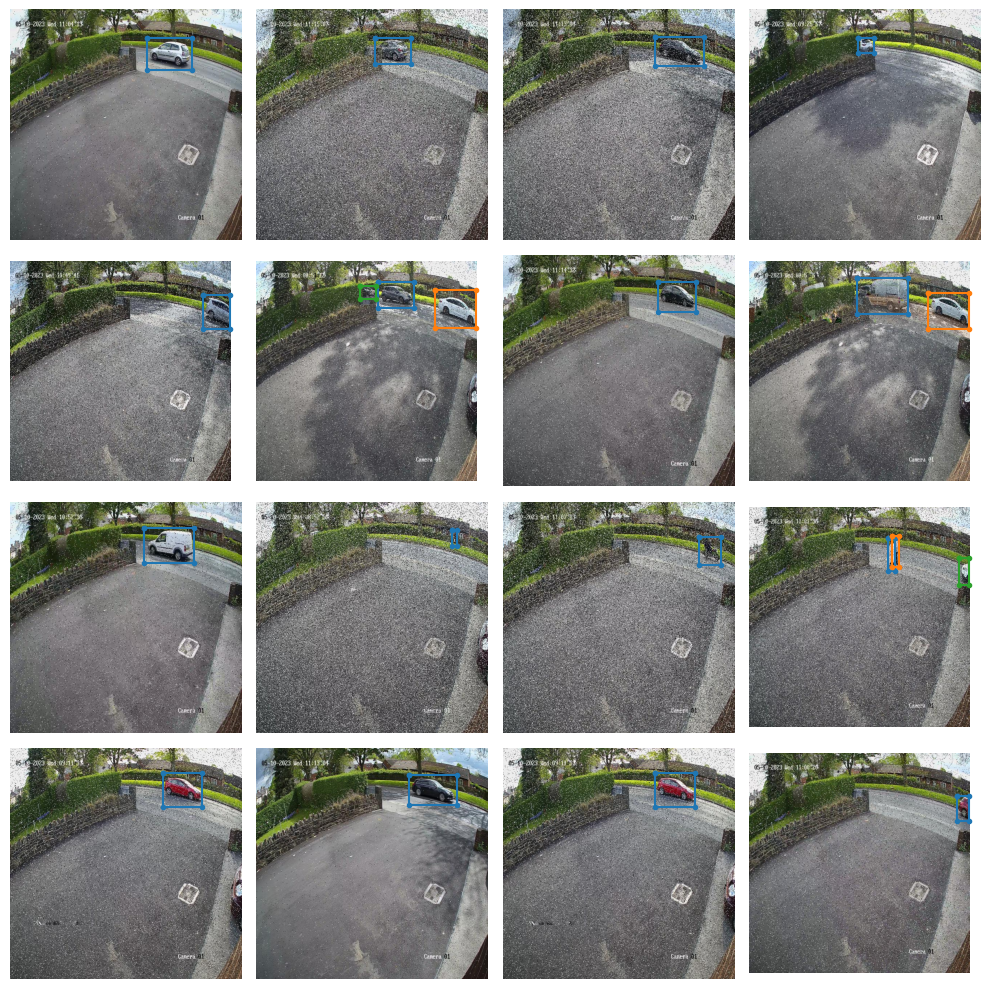

In [5]:
val_data.dataset.plot()

#### Training hyperparameters

In [6]:
train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 2,
    "mixed_precision": True,
    "loss" : PPYoloELoss (
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),

    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.8
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#### Training

##### Download the model

In [7]:
model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.PRETRAINED_WEIGHTS)

[2024-01-09 19:30:51] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /home/usuario/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:17<00:00, 4.34MB/s]
[2024-01-09 19:31:14] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


##### Initialize training

In [8]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

##### Train

In [9]:
trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

[2024-01-09 19:31:14] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_193114_846014`
[2024-01-09 19:31:14] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_193114_846014


The console stream is now moved to checkpoints/Project/RUN_20240109_193114_846014/console_Jan09_19_31_14.txt


[2024-01-09 19:31:17] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
Can't initialize NVML
[2024-01-09 19:31:19] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:         

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 3.1915
│   ├── Ppyoloeloss/loss_iou = 0.9489
│   ├── Ppyoloeloss/loss_dfl = 0.8749
│   └── Ppyoloeloss/loss = 5.0152
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.3775
    ├── Ppyoloeloss/loss_iou = 0.7027
    ├── Ppyoloeloss/loss_dfl = 0.6332
    ├── Ppyoloeloss/loss = 3.7134
    ├── Precision@0.50 = 0.0003
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0002
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it]
[2024-01-09 19:38:55] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_193114_846014/ckpt_best.pth
[2024-01-09 19:38:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0003569447435438633


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9819
│   │   ├── Epoch N-1      = 3.1915 (↘ -1.2095)
│   │   └── Best until now = 3.1915 (↘ -1.2095)
│   ├── Ppyoloeloss/loss_iou = 0.826
│   │   ├── Epoch N-1      = 0.9489 (↘ -0.1229)
│   │   └── Best until now = 0.9489 (↘ -0.1229)
│   ├── Ppyoloeloss/loss_dfl = 0.7266
│   │   ├── Epoch N-1      = 0.8749 (↘ -0.1482)
│   │   └── Best until now = 0.8749 (↘ -0.1482)
│   └── Ppyoloeloss/loss = 3.5345
│       ├── Epoch N-1      = 5.0152 (↘ -1.4807)
│       └── Best until now = 5.0152 (↘ -1.4807)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7368
    │   ├── Epoch N-1      = 2.3775 (↘ -0.6407)
    │   └── Best until now = 2.3775 (↘ -0.6407)
    ├── Ppyoloeloss/loss_iou = 1.4386
    │   ├── Epoch N-1      = 0.7027 (↗ 0.7359)
    │   └── Best until now = 0.7027 (↗ 0.7359)
    ├── Ppyoloeloss/loss_dfl = 1.1937
    │   ├── Epoch N-1      = 0.6332 (↗ 0.5606)
    │   └── Best until now = 0.6332 (↗ 0.5606)
    ├── Ppyoloeloss/loss = 

[2024-01-09 19:38:55] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2:  89%|████████▉ | 8/9 [00:55<00:06,  6.73s/it]

#### Charge best model

In [14]:
import os

avg_model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME,'RUN_20240109_193114_846014', 'average_model.pth'))

[2024-01-09 19:44:41] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/Project/RUN_20240109_193114_846014/average_model.pth EMA checkpoint.


#### Test with test_dataloaders

In [15]:
trainer.test(
    model=avg_model, 
    test_loader=test_data, 
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1, 
        top_k_predictions=300, 
        num_cls=config.NUM_CLASSES, 
        normalize_targets=True, 
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing:  89%|████████▉ | 8/9 [00:55<00:07,  7.07s/it]

{'PPYoloELoss/loss_cls': 1.7853093,
 'PPYoloELoss/loss_iou': 1.4041334,
 'PPYoloELoss/loss_dfl': 1.1722769,
 'PPYoloELoss/loss': 4.361719,
 'Precision@0.50': 0.0017123287543654442,
 'Recall@0.50': 0.005649717524647713,
 'mAP@0.50': 0.00033967173658311367,
 'F1@0.50': 0.0026281210593879223}

Testing: 100%|██████████| 9/9 [01:02<00:00,  6.91s/it]


#### Visualization

In [21]:
import random
import supervision as sv

random.seed(10)

##### Build dataset object

In [37]:
ds = sv.DetectionDataset.from_yolo(images_directory_path=f"{config.DATA_DIR}/test/images", annotations_directory_path=f"{config.DATA_DIR}/test/labels", data_yaml_path=f"{config.DATA_DIR}/data.yaml", force_masks=False)
predictions = {}
CONFIDENCE_THRESHOLD = 0.5

##### Inference

In [40]:
for image_name,image in ds.images.items():
    result = list(avg_model.predict(image, conf=CONFIDENCE_THRESHOLD))[0]
    detections = sv.Detections(xyxy=result.prediction.bboxes_xyxy, confidence=result.prediction.confidence, class_id=result.prediction.labels.astype(int))
    predictions[image_name] = detections

User provided device_type of 'cuda', but CUDA is not available. Disabling
[2024-01-09 20:06:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-09 20:06:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-09 20:06:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-09 20:06:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-09 20:06:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-09 20:06:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you ca

##### Plot annotations vs predictions

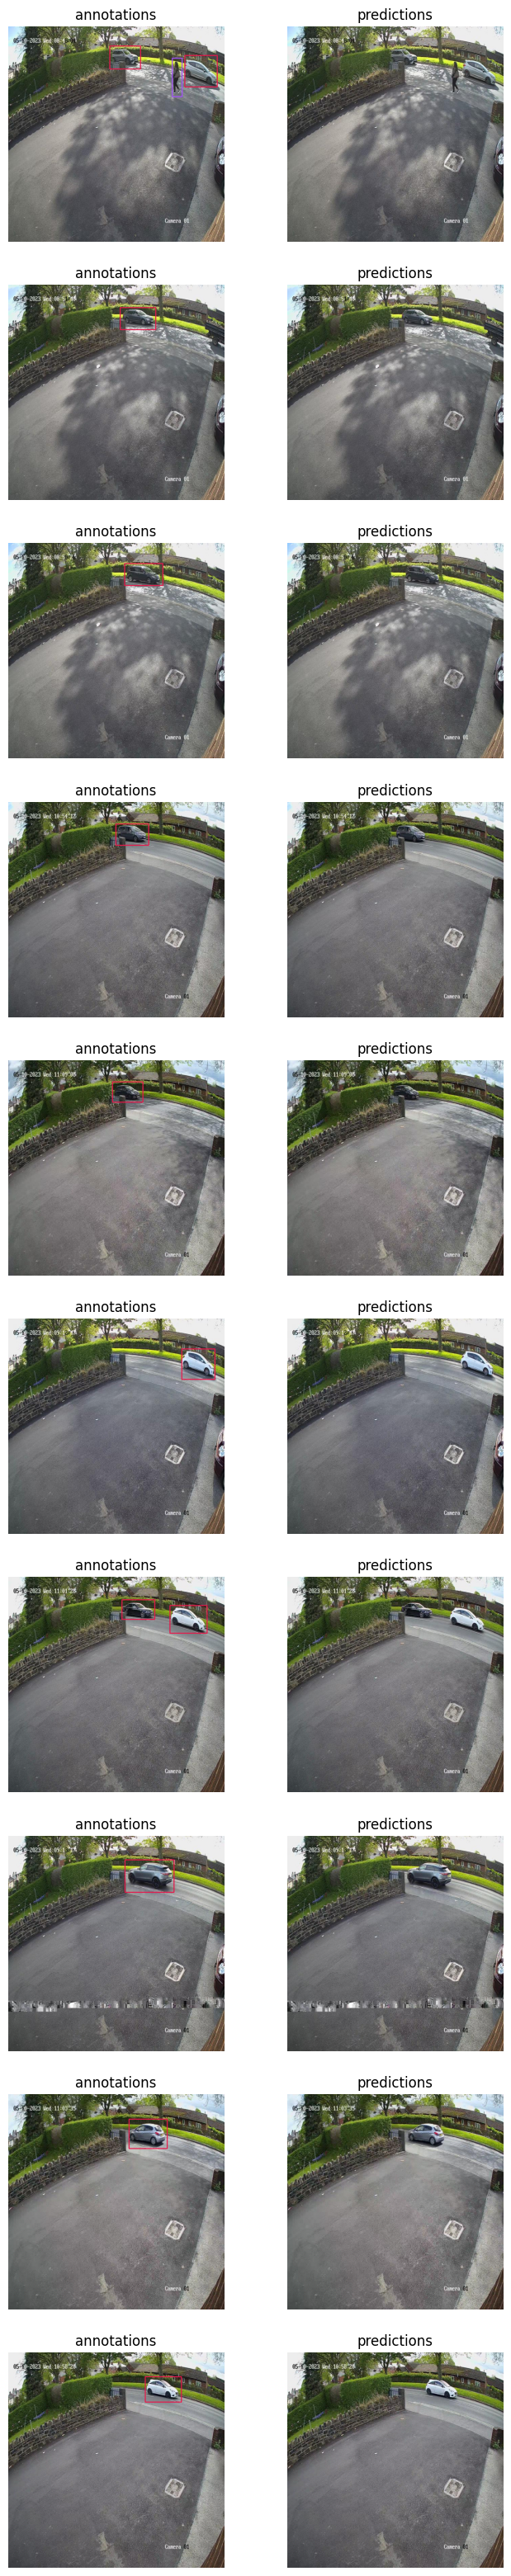

In [42]:
MAX_IMAGE_COUNT = 10
n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys,n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(scene=ds.images[key].copy (), detections =  ds. annotations [key], skip_label=True)
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator. annotate( scene = ds.images[key].copy (),detections = predictions [key], skip_label=True)
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2*4, n*4))

#### Systematically chosen hyper-parameters
We are using the random search to systematically chose the hyper-parameters. Since it takes a long time to train the model, we are only searching for the best combination of two parameters, but we can definitely use the same process for more of them. Actually, the random search would even work better with more parameters and more iterations, but as mentioned, it takes a while to do.

We decided to test multiple initial learning rates which has an impact on how much the parameters will update. We also test multiple weight decay for the optimizer. The optimizer `Adam` uses weight decay to penalize large weights to reduce overfitting tendencies. A higher value of weight decay will penalize more the large weights.

In [ ]:
import numpy as np

# Hyperparameter search space
hyperparam_space = {
    "initial_lr": [3e-4, 5e-4, 7e-4],
    "optimizer_params": [{"weight_decay": 0.0015}, {"weight_decay": 0.001}, {"weight_decay": 0.002}]
}

# Random search
num_iterations = 5
best_score = -float('inf')
best_hyperparams = None

for _ in range(num_iterations):
    # Randomly sample hyperparameters from the search space
    train_params["initial_lr"] = np.random.choice(hyperparam_space["initial_lr"])
    train_params["optimizer_params"] = np.random.choice(hyperparam_space["optimizer_params"])
    # Train the model using the sampled hyperparameters and get the score
    trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)
    test_results = trainer.test(model=model, test_loader=test_data, test_metrics_list=[
        #Accuracy(),
        DetectionMetrics_050(
            score_thres=0.1, 
            top_k_predictions=300, 
            num_cls=config.NUM_CLASSES, 
            normalize_targets=True, 
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01, 
                nms_top_k=1000, 
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ])
    print(f"Test results: DetectionMetrics: {test_results}")
    #score = test_results['Accuracy']

    # Check if the current score is better than the previous best
    #if score > best_score:
        #best_score = score 
        #best_hyperparams = {"initial_lr": train_params["initial_lr"], "optimizer_params": train_params["optimizer_params"]}
#print(best_score)
#print(best_hyperparams)

# Use the best parameters for the next step
#train_params["initial_lr"] = best_hyperparams["initial_lr"]
#train_params["optimizer_params"] = best_hyperparams["optimizer_params"]

[2024-01-09 20:39:01] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_203901_724862`
[2024-01-09 20:39:01] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_203901_724862


The console stream is now moved to checkpoints/Project/RUN_20240109_203901_724862/console_Jan09_20_39_01.txt


[2024-01-09 20:39:04] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 20:39:04] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0935
│   ├── Ppyoloeloss/loss_iou = 0.5644
│   ├── Ppyoloeloss/loss_dfl = 0.5167
│   └── Ppyoloeloss/loss = 2.1746
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5442
    ├── Ppyoloeloss/loss_iou = 0.8176
    ├── Ppyoloeloss/loss_dfl = 0.7399
    ├── Ppyoloeloss/loss = 3.1017
    ├── Precision@0.50 = 0.107
    ├── Recall@0.50 = 0.4796
    ├── Map@0.50 = 0.0426
    └── F1@0.50 = 0.0818



Validating epoch 1: 100%|██████████| 9/9 [00:59<00:00,  6.59s/it]
[2024-01-09 20:46:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_203901_724862/ckpt_best.pth
[2024-01-09 20:46:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.41246965527534485


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0324
│   │   ├── Epoch N-1      = 1.0935 (↘ -0.0611)
│   │   └── Best until now = 1.0935 (↘ -0.0611)
│   ├── Ppyoloeloss/loss_iou = 0.5512
│   │   ├── Epoch N-1      = 0.5644 (↘ -0.0132)
│   │   └── Best until now = 0.5644 (↘ -0.0132)
│   ├── Ppyoloeloss/loss_dfl = 0.5355
│   │   ├── Epoch N-1      = 0.5167 (↗ 0.0188)
│   │   └── Best until now = 0.5167 (↗ 0.0188)
│   └── Ppyoloeloss/loss = 2.1191
│       ├── Epoch N-1      = 2.1746 (↘ -0.0555)
│       └── Best until now = 2.1746 (↘ -0.0555)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4433
    │   ├── Epoch N-1      = 1.5442 (↘ -0.1009)
    │   └── Best until now = 1.5442 (↘ -0.1009)
    ├── Ppyoloeloss/loss_iou = 0.6006
    │   ├── Epoch N-1      = 0.8176 (↘ -0.2169)
    │   └── Best until now = 0.8176 (↘ -0.2169)
    ├── Ppyoloeloss/loss_dfl = 0.5716
    │   ├── Epoch N-1      = 0.7399 (↘ -0.1683)
    │   └── Best until now = 0.7399 (↘ -0.1683)
    ├── Ppyoloeloss/loss

[2024-01-09 20:46:53] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [01:00<00:00,  6.74s/it]
[2024-01-09 20:47:54] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:59<00:00,  6.60s/it]
[2024-01-09 20:48:53] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_204853_622195`
[2024-01-09 20:48:53] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_204853_622195


Test results: DetectionMetrics: {'PPYoloELoss/loss_cls': 1.475659, 'PPYoloELoss/loss_iou': 0.59561026, 'PPYoloELoss/loss_dfl': 0.5706504, 'PPYoloELoss/loss': 2.6419194, 'Precision@0.50': 0.0075072599574923515, 'Recall@0.50': 0.7924482822418213, 'mAP@0.50': 0.3978824019432068, 'F1@0.50': 0.0147549444809556}
The console stream is now moved to checkpoints/Project/RUN_20240109_204853_622195/console_Jan09_20_48_53.txt


[2024-01-09 20:48:56] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 20:48:56] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8758
│   ├── Ppyoloeloss/loss_iou = 0.5058
│   ├── Ppyoloeloss/loss_dfl = 0.5194
│   └── Ppyoloeloss/loss = 1.9011
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2185
    ├── Ppyoloeloss/loss_iou = 0.4979
    ├── Ppyoloeloss/loss_dfl = 0.5047
    ├── Ppyoloeloss/loss = 2.2212
    ├── Precision@0.50 = 0.0059
    ├── Recall@0.50 = 0.9246
    ├── Map@0.50 = 0.5362
    └── F1@0.50 = 0.0117



Validating epoch 1: 100%|██████████| 9/9 [01:00<00:00,  6.72s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9626
│   │   ├── Epoch N-1      = 0.8758 (↗ 0.0868)
│   │   └── Best until now = 0.8758 (↗ 0.0868)
│   ├── Ppyoloeloss/loss_iou = 0.5144
│   │   ├── Epoch N-1      = 0.5058 (↗ 0.0086)
│   │   └── Best until now = 0.5058 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.5293
│   │   ├── Epoch N-1      = 0.5194 (↗ 0.0099)
│   │   └── Best until now = 0.5194 (↗ 0.0099)
│   └── Ppyoloeloss/loss = 2.0063
│       ├── Epoch N-1      = 1.9011 (↗ 0.1053)
│       └── Best until now = 1.9011 (↗ 0.1053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6228
    │   ├── Epoch N-1      = 1.2185 (↗ 0.4043)
    │   └── Best until now = 1.2185 (↗ 0.4043)
    ├── Ppyoloeloss/loss_iou = 0.5749
    │   ├── Epoch N-1      = 0.4979 (↗ 0.077)
    │   └── Best until now = 0.4979 (↗ 0.077)
    ├── Ppyoloeloss/loss_dfl = 0.6082
    │   ├── Epoch N-1      = 0.5047 (↗ 0.1035)
    │   └── Best until now = 0.5047 (↗ 0.1035)
    ├── Ppyoloeloss/loss = 2.806
    │

[2024-01-09 20:56:39] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]
[2024-01-09 20:57:38] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]
[2024-01-09 20:58:34] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_205834_545691`
[2024-01-09 20:58:34] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_205834_545691


Test results: DetectionMetrics: {'PPYoloELoss/loss_cls': 1.632937, 'PPYoloELoss/loss_iou': 0.5702429, 'PPYoloELoss/loss_dfl': 0.6059136, 'PPYoloELoss/loss': 2.8090932, 'Precision@0.50': 0.0039793960750103, 'Recall@0.50': 0.927106499671936, 'mAP@0.50': 0.39121097326278687, 'F1@0.50': 0.007922366261482239}
The console stream is now moved to checkpoints/Project/RUN_20240109_205834_545691/console_Jan09_20_58_34.txt


[2024-01-09 20:58:36] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 20:58:37] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8652
│   ├── Ppyoloeloss/loss_iou = 0.4636
│   ├── Ppyoloeloss/loss_dfl = 0.4664
│   └── Ppyoloeloss/loss = 1.7952
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9271
    ├── Ppyoloeloss/loss_iou = 0.6701
    ├── Ppyoloeloss/loss_dfl = 0.6537
    ├── Ppyoloeloss/loss = 3.251
    ├── Precision@0.50 = 0.0056
    ├── Recall@0.50 = 0.8446
    ├── Map@0.50 = 0.34
    └── F1@0.50 = 0.0111



Validating epoch 1: 100%|██████████| 9/9 [00:58<00:00,  6.50s/it]
[2024-01-09 21:05:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_205834_545691/ckpt_best.pth
[2024-01-09 21:05:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6488522887229919


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.904
│   │   ├── Epoch N-1      = 0.8652 (↗ 0.0388)
│   │   └── Best until now = 0.8652 (↗ 0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.5055
│   │   ├── Epoch N-1      = 0.4636 (↗ 0.0419)
│   │   └── Best until now = 0.4636 (↗ 0.0419)
│   ├── Ppyoloeloss/loss_dfl = 0.5284
│   │   ├── Epoch N-1      = 0.4664 (↗ 0.0619)
│   │   └── Best until now = 0.4664 (↗ 0.0619)
│   └── Ppyoloeloss/loss = 1.9379
│       ├── Epoch N-1      = 1.7952 (↗ 0.1427)
│       └── Best until now = 1.7952 (↗ 0.1427)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.154
    │   ├── Epoch N-1      = 1.9271 (↘ -0.7732)
    │   └── Best until now = 1.9271 (↘ -0.7732)
    ├── Ppyoloeloss/loss_iou = 0.5284
    │   ├── Epoch N-1      = 0.6701 (↘ -0.1417)
    │   └── Best until now = 0.6701 (↘ -0.1417)
    ├── Ppyoloeloss/loss_dfl = 0.6193
    │   ├── Epoch N-1      = 0.6537 (↘ -0.0344)
    │   └── Best until now = 0.6537 (↘ -0.0344)
    ├── Ppyoloeloss/loss = 2.301

[2024-01-09 21:05:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:59<00:00,  6.62s/it]
[2024-01-09 21:06:47] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:59<00:00,  6.60s/it]
[2024-01-09 21:07:47] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_210747_397556`
[2024-01-09 21:07:47] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_210747_397556


Test results: DetectionMetrics: {'PPYoloELoss/loss_cls': 1.1568749, 'PPYoloELoss/loss_iou': 0.5261184, 'PPYoloELoss/loss_dfl': 0.61728895, 'PPYoloELoss/loss': 2.3002822, 'Precision@0.50': 0.009180799126625061, 'Recall@0.50': 0.958267092704773, 'mAP@0.50': 0.6751642227172852, 'F1@0.50': 0.018112417310476303}
The console stream is now moved to checkpoints/Project/RUN_20240109_210747_397556/console_Jan09_21_07_47.txt


[2024-01-09 21:07:49] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:07:50] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8482
│   ├── Ppyoloeloss/loss_iou = 0.45
│   ├── Ppyoloeloss/loss_dfl = 0.4992
│   └── Ppyoloeloss/loss = 1.7974
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1308
    ├── Ppyoloeloss/loss_iou = 0.5392
    ├── Ppyoloeloss/loss_dfl = 0.6256
    ├── Ppyoloeloss/loss = 2.2956
    ├── Precision@0.50 = 0.0086
    ├── Recall@0.50 = 0.9857
    ├── Map@0.50 = 0.6741
    └── F1@0.50 = 0.017



Validating epoch 1: 100%|██████████| 9/9 [01:00<00:00,  6.71s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8767
│   │   ├── Epoch N-1      = 0.8482 (↗ 0.0285)
│   │   └── Best until now = 0.8482 (↗ 0.0285)
│   ├── Ppyoloeloss/loss_iou = 0.4452
│   │   ├── Epoch N-1      = 0.45   (↘ -0.0048)
│   │   └── Best until now = 0.45   (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.4803
│   │   ├── Epoch N-1      = 0.4992 (↘ -0.0189)
│   │   └── Best until now = 0.4992 (↘ -0.0189)
│   └── Ppyoloeloss/loss = 1.8023
│       ├── Epoch N-1      = 1.7974 (↗ 0.0049)
│       └── Best until now = 1.7974 (↗ 0.0049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 19.2
    │   ├── Epoch N-1      = 1.1308 (↗ 18.0692)
    │   └── Best until now = 1.1308 (↗ 18.0692)
    ├── Ppyoloeloss/loss_iou = 0.6095
    │   ├── Epoch N-1      = 0.5392 (↗ 0.0703)
    │   └── Best until now = 0.5392 (↗ 0.0703)
    ├── Ppyoloeloss/loss_dfl = 0.667
    │   ├── Epoch N-1      = 0.6256 (↗ 0.0414)
    │   └── Best until now = 0.6256 (↗ 0.0414)
    ├── Ppyoloeloss/loss = 20.476

[2024-01-09 21:15:13] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:59<00:00,  6.63s/it]
[2024-01-09 21:16:13] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:56<00:00,  6.33s/it]
[2024-01-09 21:17:10] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_211710_052248`
[2024-01-09 21:17:10] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_211710_052248


Test results: DetectionMetrics: {'PPYoloELoss/loss_cls': 19.157692, 'PPYoloELoss/loss_iou': 0.60420364, 'PPYoloELoss/loss_dfl': 0.6652547, 'PPYoloELoss/loss': 20.42715, 'Precision@0.50': 0.04845074936747551, 'Recall@0.50': 0.768441915512085, 'mAP@0.50': 0.2965881824493408, 'F1@0.50': 0.0851350724697113}
The console stream is now moved to checkpoints/Project/RUN_20240109_211710_052248/console_Jan09_21_17_10.txt


[2024-01-09 21:17:12] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:17:13] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7688
│   ├── Ppyoloeloss/loss_iou = 0.4241
│   ├── Ppyoloeloss/loss_dfl = 0.4498
│   └── Ppyoloeloss/loss = 1.6427
└── Validation
    ├── Ppyoloeloss/loss_cls = 5.8036
    ├── Ppyoloeloss/loss_iou = 0.6257
    ├── Ppyoloeloss/loss_dfl = 0.689
    ├── Ppyoloeloss/loss = 7.1183
    ├── Precision@0.50 = 0.0069
    ├── Recall@0.50 = 0.8746
    ├── Map@0.50 = 0.2928
    └── F1@0.50 = 0.0137



Validating epoch 1: 100%|██████████| 9/9 [00:46<00:00,  5.16s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8149
│   │   ├── Epoch N-1      = 0.7688 (↗ 0.0461)
│   │   └── Best until now = 0.7688 (↗ 0.0461)
│   ├── Ppyoloeloss/loss_iou = 0.4431
│   │   ├── Epoch N-1      = 0.4241 (↗ 0.019)
│   │   └── Best until now = 0.4241 (↗ 0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.4751
│   │   ├── Epoch N-1      = 0.4498 (↗ 0.0254)
│   │   └── Best until now = 0.4498 (↗ 0.0254)
│   └── Ppyoloeloss/loss = 1.7332
│       ├── Epoch N-1      = 1.6427 (↗ 0.0904)
│       └── Best until now = 1.6427 (↗ 0.0904)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6682
    │   ├── Epoch N-1      = 5.8036 (↘ -4.1353)
    │   └── Best until now = 5.8036 (↘ -4.1353)
    ├── Ppyoloeloss/loss_iou = 0.915
    │   ├── Epoch N-1      = 0.6257 (↗ 0.2893)
    │   └── Best until now = 0.6257 (↗ 0.2893)
    ├── Ppyoloeloss/loss_dfl = 0.986
    │   ├── Epoch N-1      = 0.689  (↗ 0.297)
    │   └── Best until now = 0.689  (↗ 0.297)
    ├── Ppyoloeloss/loss = 3.5692
    │ 

[2024-01-09 21:24:26] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:46<00:00,  5.15s/it]
[2024-01-09 21:25:13] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing:  89%|████████▉ | 8/9 [00:41<00:05,  5.14s/it]

Testing: 100%|██████████| 9/9 [00:46<00:00,  5.15s/it]


Test results: DetectionMetrics: {'PPYoloELoss/loss_cls': 1.6973963, 'PPYoloELoss/loss_iou': 0.9353766, 'PPYoloELoss/loss_dfl': 1.0100648, 'PPYoloELoss/loss': 3.642838, 'Precision@0.50': 0.005387923214584589, 'Recall@0.50': 0.7306041717529297, 'mAP@0.50': 0.1999201774597168, 'F1@0.50': 0.010605107992887497}


In [48]:
for metric_name, metric_value in test_results.items():
    print(f"{metric_name}: {metric_value}")


PPYoloELoss/loss_cls: 1.6973962783813477
PPYoloELoss/loss_iou: 0.9353765845298767
PPYoloELoss/loss_dfl: 1.0100648403167725
PPYoloELoss/loss: 3.6428380012512207
Precision@0.50: 0.005387923214584589
Recall@0.50: 0.7306041717529297
mAP@0.50: 0.1999201774597168
F1@0.50: 0.010605107992887497


#### Cross-validation
When we first downloaded the data, it got separated into three folders: test, train, validate. For cross-validation, we will use `KFold` method from `scikit-learn` which divides our data into folds. More specifically, it will divide the training data into multiples folds for training and one for test data. However, since we already have a testing folder, we will disregard the one generated by the function `KFold``. We will also disregard the validate folder, as the process of cross-validation already does validation with one of the folds.

#### Performance of different seeds
The function `KFold` accepts a parameter `random_state` to set a seed for the randomization of the elements in each fold. More specifically, the items in the dataset are shuffled before getting split. We will test three different seeds and evaluate their performance through precision and recall metrics.

In [49]:
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold

def read_data(path):
    dataset = []
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if "images" in path:
            file = cv2.imread(file_path)
        if "labels" in path:
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    file = []
                    for line in lines:
                        values = line.strip().split()
                        try:
                            # Convert label to integer (values[0]) and ensure rest are floats
                            label = int(float(values[0]))
                            bbox_coords = [float(val) for val in values[1:]]
                            annotation = [label] + bbox_coords
                            file.append(annotation)
                        except ValueError as e:
                            print(f"Error parsing line '{line}' of file {file_path}: {e}")
                    file = np.array(file)
        dataset.append(file)
    return np.array(dataset)

def write_data(dataset, path):
    if not os.path.exists(path):
        os.makedirs(path)

    for i, file in enumerate(dataset):
        if "images" in path:
            filename = f"{i}.jpg"
            output_path = os.path.join(path, filename)
            cv2.imwrite(output_path, file)
        if "labels" in path:
            for i, annotation in enumerate(dataset):
                filename = f"{i}.txt"
                output_path = os.path.join(path, filename)

                with open(output_path, 'w') as file:
                    for value in annotation:
                        # Convert label to integer and keep bounding box coordinates as floats
                        label = str(int(value[0]))
                        bbox_coords = ' '.join([str(coord) for coord in value[1:]])
                        line = label + ' ' + bbox_coords
                        file.write(line)
                        file.write('\n')

def cross_validation(values, labels, seed):
    current_iteration = 0
    accuracies = []
    precisions = []
    recalls = []
    num_folds = 3
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    for train_index, test_index in kf.split(values):
        values_train, _ = values[train_index], values[test_index]
        labels_train, _ = labels[train_index], labels[test_index]

        # In order to use the training function, we need to store the images and labels in respective folders
        output_path = dataset.location + f"/train_fold_{current_iteration}"
        write_data(values_train, output_path + "/images")
        write_data(labels_train, output_path + "/labels")
        
        # Converts our new separated datasets into Dataloaders
        train_data = coco_detection_yolo_format_train(
            dataset_params={
                'data_dir': config.DATA_DIR,
                'images_dir': f"train_fold_{current_iteration}/images", 
                'labels_dir': f"train_fold_{current_iteration}/labels",
                'classes': config.CLASSES,
                'show_all_warnings': True,
            },
            dataloader_params=config.DATALOADER_PARAMS
        )
        # Train and test
        trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)
        test_results = trainer.test(model=model, test_loader=test_data, test_metrics_list=[
            #Average(),
            DetectionMetrics_050(
                score_thres=0.1, 
                top_k_predictions=300, 
                num_cls=config.NUM_CLASSES, 
                normalize_targets=True, 
                post_prediction_callback=PPYoloEPostPredictionCallback(
                    score_threshold=0.01, 
                    nms_top_k=1000, 
                    max_predictions=300,
                    nms_threshold=0.7
                )
            )
        ])
        for metric_name, metric_value in test_results.items():
            print(f"{metric_name}: {metric_value}")
        #accuracies.append(test_results['DetectionMetrics_050'])

        current_iteration += 1

    #average_accuracy = sum(accuracies) / len(accuracies)
    #print(f"Average accuracy for seed {seed} = {average_accuracy}")        

In [ ]:
# Load data in order to split it in folds
path = dataset.location + "/train"
loaded_dataset = read_data(path + "/images")
loaded_labels = read_data(path + "/labels")
seeds = [1, 2, 3]
for seed in seeds:
    cross_validation(loaded_dataset, loaded_labels, seed)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
[2024-01-09 21:28:20] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 13295.34it/s]
[2024-01-09 21:28:20] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_212820_158743`
[2024-01-09 21:28:20] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_212820_158743


The console stream is now moved to checkpoints/Project/RUN_20240109_212820_158743/console_Jan09_21_28_20.txt


[2024-01-09 21:28:22] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:28:23] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8479
│   ├── Ppyoloeloss/loss_iou = 1.1752
│   ├── Ppyoloeloss/loss_dfl = 1.147
│   └── Ppyoloeloss/loss = 4.1701
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4865
    ├── Ppyoloeloss/loss_iou = 1.0609
    ├── Ppyoloeloss/loss_dfl = 1.2009
    ├── Ppyoloeloss/loss = 4.7483
    ├── Precision@0.50 = 0.0158
    ├── Recall@0.50 = 0.6914
    ├── Map@0.50 = 0.2453
    └── F1@0.50 = 0.0293



Validating epoch 1: 100%|██████████| 9/9 [00:51<00:00,  5.73s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5412
│   │   ├── Epoch N-1      = 1.8479 (↘ -0.3067)
│   │   └── Best until now = 1.8479 (↘ -0.3067)
│   ├── Ppyoloeloss/loss_iou = 1.022
│   │   ├── Epoch N-1      = 1.1752 (↘ -0.1532)
│   │   └── Best until now = 1.1752 (↘ -0.1532)
│   ├── Ppyoloeloss/loss_dfl = 0.9243
│   │   ├── Epoch N-1      = 1.147  (↘ -0.2227)
│   │   └── Best until now = 1.147  (↘ -0.2227)
│   └── Ppyoloeloss/loss = 3.4875
│       ├── Epoch N-1      = 4.1701 (↘ -0.6826)
│       └── Best until now = 4.1701 (↘ -0.6826)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3489
    │   ├── Epoch N-1      = 2.4865 (↘ -1.1376)
    │   └── Best until now = 2.4865 (↘ -1.1376)
    ├── Ppyoloeloss/loss_iou = 1.5475
    │   ├── Epoch N-1      = 1.0609 (↗ 0.4865)
    │   └── Best until now = 1.0609 (↗ 0.4865)
    ├── Ppyoloeloss/loss_dfl = 1.7015
    │   ├── Epoch N-1      = 1.2009 (↗ 0.5006)
    │   └── Best until now = 1.2009 (↗ 0.5006)
    ├── Ppyoloeloss/loss = 

[2024-01-09 21:33:57] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]
[2024-01-09 21:34:52] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]


PPYoloELoss/loss_cls: 1.3490691184997559
PPYoloELoss/loss_iou: 1.5649220943450928
PPYoloELoss/loss_dfl: 1.7409743070602417
PPYoloELoss/loss: 4.654965877532959
Precision@0.50: 0.00047281323350034654
Recall@0.50: 0.020588235929608345
mAP@0.50: 5.1152081141481176e-05
F1@0.50: 0.0009243974345736206


[2024-01-09 21:35:51] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 9053.99it/s]
[2024-01-09 21:35:51] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_213551_559855`
[2024-01-09 21:35:51] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_213551_559855


The console stream is now moved to checkpoints/Project/RUN_20240109_213551_559855/console_Jan09_21_35_51.txt


[2024-01-09 21:35:53] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:35:54] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3858
│   ├── Ppyoloeloss/loss_iou = 1.0209
│   ├── Ppyoloeloss/loss_dfl = 0.8333
│   └── Ppyoloeloss/loss = 3.2401
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2719
    ├── Ppyoloeloss/loss_iou = 1.5621
    ├── Ppyoloeloss/loss_dfl = 1.6223
    ├── Ppyoloeloss/loss = 4.4563
    ├── Precision@0.50 = 0.0003
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 9/9 [00:58<00:00,  6.46s/it]
[2024-01-09 21:41:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_213551_559855/ckpt_best.pth
[2024-01-09 21:41:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0006643283413723111


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2494
│   │   ├── Epoch N-1      = 1.3858 (↘ -0.1365)
│   │   └── Best until now = 1.3858 (↘ -0.1365)
│   ├── Ppyoloeloss/loss_iou = 0.9569
│   │   ├── Epoch N-1      = 1.0209 (↘ -0.064)
│   │   └── Best until now = 1.0209 (↘ -0.064)
│   ├── Ppyoloeloss/loss_dfl = 0.8142
│   │   ├── Epoch N-1      = 0.8333 (↘ -0.0192)
│   │   └── Best until now = 0.8333 (↘ -0.0192)
│   └── Ppyoloeloss/loss = 3.0205
│       ├── Epoch N-1      = 3.2401 (↘ -0.2196)
│       └── Best until now = 3.2401 (↘ -0.2196)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5796
    │   ├── Epoch N-1      = 1.2719 (↗ 0.3077)
    │   └── Best until now = 1.2719 (↗ 0.3077)
    ├── Ppyoloeloss/loss_iou = 1.1926
    │   ├── Epoch N-1      = 1.5621 (↘ -0.3695)
    │   └── Best until now = 1.5621 (↘ -0.3695)
    ├── Ppyoloeloss/loss_dfl = 1.1148
    │   ├── Epoch N-1      = 1.6223 (↘ -0.5075)
    │   └── Best until now = 1.6223 (↘ -0.5075)
    ├── Ppyoloeloss/loss =

[2024-01-09 21:41:30] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:58<00:00,  6.45s/it]
[2024-01-09 21:42:28] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:48<00:00,  5.44s/it]


PPYoloELoss/loss_cls: 1.5891671180725098
PPYoloELoss/loss_iou: 1.201098918914795
PPYoloELoss/loss_dfl: 1.120739459991455
PPYoloELoss/loss: 3.911006450653076
Precision@0.50: 0.0012185935629531741
Recall@0.50: 0.0117647061124444
mAP@0.50: 0.0007823465275578201
F1@0.50: 0.0022084361407905817


[2024-01-09 21:43:18] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 12907.42it/s]
[2024-01-09 21:43:18] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_214318_747040`
[2024-01-09 21:43:18] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_214318_747040


The console stream is now moved to checkpoints/Project/RUN_20240109_214318_747040/console_Jan09_21_43_18.txt


[2024-01-09 21:43:21] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:43:21] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2221
│   ├── Ppyoloeloss/loss_iou = 0.9465
│   ├── Ppyoloeloss/loss_dfl = 0.7823
│   └── Ppyoloeloss/loss = 2.9509
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.708
    ├── Ppyoloeloss/loss_iou = 1.027
    ├── Ppyoloeloss/loss_dfl = 0.9457
    ├── Ppyoloeloss/loss = 3.6807
    ├── Precision@0.50 = 0.0038
    ├── Recall@0.50 = 0.0571
    ├── Map@0.50 = 0.0012
    └── F1@0.50 = 0.003



Validating epoch 1: 100%|██████████| 9/9 [00:46<00:00,  5.22s/it]
[2024-01-09 21:47:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_214318_747040/ckpt_best.pth
[2024-01-09 21:47:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0035602382849901915


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2343
│   │   ├── Epoch N-1      = 1.2221 (↗ 0.0122)
│   │   └── Best until now = 1.2221 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.9176
│   │   ├── Epoch N-1      = 0.9465 (↘ -0.029)
│   │   └── Best until now = 0.9465 (↘ -0.029)
│   ├── Ppyoloeloss/loss_dfl = 0.7861
│   │   ├── Epoch N-1      = 0.7823 (↗ 0.0038)
│   │   └── Best until now = 0.7823 (↗ 0.0038)
│   └── Ppyoloeloss/loss = 2.9379
│       ├── Epoch N-1      = 2.9509 (↘ -0.013)
│       └── Best until now = 2.9509 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3311
    │   ├── Epoch N-1      = 1.708  (↘ -0.3769)
    │   └── Best until now = 1.708  (↘ -0.3769)
    ├── Ppyoloeloss/loss_iou = 1.2633
    │   ├── Epoch N-1      = 1.027  (↗ 0.2363)
    │   └── Best until now = 1.027  (↗ 0.2363)
    ├── Ppyoloeloss/loss_dfl = 1.2041
    │   ├── Epoch N-1      = 0.9457 (↗ 0.2584)
    │   └── Best until now = 0.9457 (↗ 0.2584)
    ├── Ppyoloeloss/loss = 3.7984


[2024-01-09 21:47:53] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:46<00:00,  5.15s/it]
[2024-01-09 21:48:39] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:46<00:00,  5.18s/it]


PPYoloELoss/loss_cls: 1.305213451385498
PPYoloELoss/loss_iou: 1.2757576704025269
PPYoloELoss/loss_dfl: 1.216064214706421
PPYoloELoss/loss: 3.797034740447998
Precision@0.50: 0.015248209238052368
Recall@0.50: 0.008823529817163944
mAP@0.50: 0.0036891743075102568
F1@0.50: 0.005394297651946545


[2024-01-09 21:49:27] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 13302.10it/s]
[2024-01-09 21:49:27] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_214927_646789`
[2024-01-09 21:49:27] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_214927_646789


The console stream is now moved to checkpoints/Project/RUN_20240109_214927_646789/console_Jan09_21_49_27.txt


[2024-01-09 21:49:29] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:49:30] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2217
│   ├── Ppyoloeloss/loss_iou = 0.8921
│   ├── Ppyoloeloss/loss_dfl = 0.7572
│   └── Ppyoloeloss/loss = 2.871
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4505
    ├── Ppyoloeloss/loss_iou = 1.0853
    ├── Ppyoloeloss/loss_dfl = 0.9861
    ├── Ppyoloeloss/loss = 3.5218
    ├── Precision@0.50 = 0.0328
    ├── Recall@0.50 = 0.1596
    ├── Map@0.50 = 0.0108
    └── F1@0.50 = 0.0459



Validating epoch 1: 100%|██████████| 9/9 [00:55<00:00,  6.12s/it]
[2024-01-09 21:54:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_214927_646789/ckpt_best.pth
[2024-01-09 21:54:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0204891599714756


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2028
│   │   ├── Epoch N-1      = 1.2217 (↘ -0.019)
│   │   └── Best until now = 1.2217 (↘ -0.019)
│   ├── Ppyoloeloss/loss_iou = 0.8592
│   │   ├── Epoch N-1      = 0.8921 (↘ -0.0329)
│   │   └── Best until now = 0.8921 (↘ -0.0329)
│   ├── Ppyoloeloss/loss_dfl = 0.7564
│   │   ├── Epoch N-1      = 0.7572 (↘ -0.0009)
│   │   └── Best until now = 0.7572 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 2.8183
│       ├── Epoch N-1      = 2.871  (↘ -0.0527)
│       └── Best until now = 2.871  (↘ -0.0527)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4663
    │   ├── Epoch N-1      = 1.4505 (↗ 0.0158)
    │   └── Best until now = 1.4505 (↗ 0.0158)
    ├── Ppyoloeloss/loss_iou = 0.7665
    │   ├── Epoch N-1      = 1.0853 (↘ -0.3188)
    │   └── Best until now = 1.0853 (↘ -0.3188)
    ├── Ppyoloeloss/loss_dfl = 0.7387
    │   ├── Epoch N-1      = 0.9861 (↘ -0.2474)
    │   └── Best until now = 0.9861 (↘ -0.2474)
    ├── Ppyoloeloss/loss =

[2024-01-09 21:54:10] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:58<00:00,  6.51s/it]
[2024-01-09 21:55:09] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:57<00:00,  6.41s/it]


PPYoloELoss/loss_cls: 1.4743727445602417
PPYoloELoss/loss_iou: 0.7503147721290588
PPYoloELoss/loss_dfl: 0.7314756512641907
PPYoloELoss/loss: 2.956163167953491
Precision@0.50: 0.018568994477391243
Recall@0.50: 0.5123211145401001
mAP@0.50: 0.0385601781308651
F1@0.50: 0.025057531893253326


[2024-01-09 21:56:08] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 11627.38it/s]
[2024-01-09 21:56:08] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_215608_328987`
[2024-01-09 21:56:08] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_215608_328987


The console stream is now moved to checkpoints/Project/RUN_20240109_215608_328987/console_Jan09_21_56_08.txt


[2024-01-09 21:56:10] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 21:56:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2284
│   ├── Ppyoloeloss/loss_iou = 0.8981
│   ├── Ppyoloeloss/loss_dfl = 0.7853
│   └── Ppyoloeloss/loss = 2.9118
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5425
    ├── Ppyoloeloss/loss_iou = 0.766
    ├── Ppyoloeloss/loss_dfl = 0.7372
    ├── Ppyoloeloss/loss = 3.0457
    ├── Precision@0.50 = 0.0019
    ├── Recall@0.50 = 0.4743
    ├── Map@0.50 = 0.0066
    └── F1@0.50 = 0.0038



Validating epoch 1: 100%|██████████| 9/9 [00:47<00:00,  5.22s/it]
[2024-01-09 22:01:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_215608_328987/ckpt_best.pth
[2024-01-09 22:01:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.039383549243211746


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2565
│   │   ├── Epoch N-1      = 1.2284 (↗ 0.0281)
│   │   └── Best until now = 1.2284 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_iou = 0.8331
│   │   ├── Epoch N-1      = 0.8981 (↘ -0.065)
│   │   └── Best until now = 0.8981 (↘ -0.065)
│   ├── Ppyoloeloss/loss_dfl = 0.7596
│   │   ├── Epoch N-1      = 0.7853 (↘ -0.0258)
│   │   └── Best until now = 0.7853 (↘ -0.0258)
│   └── Ppyoloeloss/loss = 2.8492
│       ├── Epoch N-1      = 2.9118 (↘ -0.0627)
│       └── Best until now = 2.9118 (↘ -0.0627)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3422
    │   ├── Epoch N-1      = 1.5425 (↘ -0.2003)
    │   └── Best until now = 1.5425 (↘ -0.2003)
    ├── Ppyoloeloss/loss_iou = 0.8445
    │   ├── Epoch N-1      = 0.766  (↗ 0.0786)
    │   └── Best until now = 0.766  (↗ 0.0786)
    ├── Ppyoloeloss/loss_dfl = 0.7391
    │   ├── Epoch N-1      = 0.7372 (↗ 0.0019)
    │   └── Best until now = 0.7372 (↗ 0.0019)
    ├── Ppyoloeloss/loss = 2.9

[2024-01-09 22:01:26] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:46<00:00,  5.12s/it]
[2024-01-09 22:02:12] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]


PPYoloELoss/loss_cls: 1.3489161729812622
PPYoloELoss/loss_iou: 0.8381396532058716
PPYoloELoss/loss_dfl: 0.7339955568313599
PPYoloELoss/loss: 2.921051502227783
Precision@0.50: 0.00896280724555254
Recall@0.50: 0.4980922341346741
mAP@0.50: 0.046613872051239014
F1@0.50: 0.017387300729751587


[2024-01-09 22:03:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 11230.01it/s]
[2024-01-09 22:03:11] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_220311_086387`
[2024-01-09 22:03:11] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_220311_086387


The console stream is now moved to checkpoints/Project/RUN_20240109_220311_086387/console_Jan09_22_03_11.txt


[2024-01-09 22:03:13] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 22:03:14] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2554
│   ├── Ppyoloeloss/loss_iou = 0.8393
│   ├── Ppyoloeloss/loss_dfl = 0.7521
│   └── Ppyoloeloss/loss = 2.8468
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3491
    ├── Ppyoloeloss/loss_iou = 0.8504
    ├── Ppyoloeloss/loss_dfl = 0.7346
    ├── Ppyoloeloss/loss = 2.9341
    ├── Precision@0.50 = 0.006
    ├── Recall@0.50 = 0.5604
    ├── Map@0.50 = 0.0481
    └── F1@0.50 = 0.0117



Validating epoch 1: 100%|██████████| 9/9 [00:50<00:00,  5.64s/it]
[2024-01-09 22:08:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_220311_086387/ckpt_best.pth
[2024-01-09 22:08:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.05653432756662369


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2143
│   │   ├── Epoch N-1      = 1.2554 (↘ -0.0411)
│   │   └── Best until now = 1.2554 (↘ -0.0411)
│   ├── Ppyoloeloss/loss_iou = 0.8258
│   │   ├── Epoch N-1      = 0.8393 (↘ -0.0135)
│   │   └── Best until now = 0.8393 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.7502
│   │   ├── Epoch N-1      = 0.7521 (↘ -0.0019)
│   │   └── Best until now = 0.7521 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 2.7903
│       ├── Epoch N-1      = 2.8468 (↘ -0.0565)
│       └── Best until now = 2.8468 (↘ -0.0565)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4024
    │   ├── Epoch N-1      = 1.3491 (↗ 0.0532)
    │   └── Best until now = 1.3491 (↗ 0.0532)
    ├── Ppyoloeloss/loss_iou = 0.8255
    │   ├── Epoch N-1      = 0.8504 (↘ -0.0249)
    │   └── Best until now = 0.8504 (↘ -0.0249)
    ├── Ppyoloeloss/loss_dfl = 0.7369
    │   ├── Epoch N-1      = 0.7346 (↗ 0.0023)
    │   └── Best until now = 0.7346 (↗ 0.0023)
    ├── Ppyoloeloss/loss =

[2024-01-09 22:08:58] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]
[2024-01-09 22:09:48] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:50<00:00,  5.60s/it]


PPYoloELoss/loss_cls: 1.4060324430465698
PPYoloELoss/loss_iou: 0.8180810213088989
PPYoloELoss/loss_dfl: 0.7326434850692749
PPYoloELoss/loss: 2.956756830215454
Precision@0.50: 0.33650442957878113
Recall@0.50: 0.4529411792755127
mAP@0.50: 0.08537038415670395
F1@0.50: 0.006298053078353405


[2024-01-09 22:10:40] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 13378.15it/s]
[2024-01-09 22:10:40] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_221040_548694`
[2024-01-09 22:10:40] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_221040_548694


The console stream is now moved to checkpoints/Project/RUN_20240109_221040_548694/console_Jan09_22_10_40.txt


[2024-01-09 22:10:42] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 22:10:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2451
│   ├── Ppyoloeloss/loss_iou = 0.8465
│   ├── Ppyoloeloss/loss_dfl = 0.75
│   └── Ppyoloeloss/loss = 2.8416
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4187
    ├── Ppyoloeloss/loss_iou = 0.8046
    ├── Ppyoloeloss/loss_dfl = 0.718
    ├── Ppyoloeloss/loss = 2.9414
    ├── Precision@0.50 = 0.002
    ├── Recall@0.50 = 0.4514
    ├── Map@0.50 = 0.0044
    └── F1@0.50 = 0.004



Validating epoch 1: 100%|██████████| 9/9 [00:50<00:00,  5.63s/it]
[2024-01-09 22:15:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_221040_548694/ckpt_best.pth
[2024-01-09 22:15:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.028747674077749252


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2765
│   │   ├── Epoch N-1      = 1.2451 (↗ 0.0313)
│   │   └── Best until now = 1.2451 (↗ 0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.7772
│   │   ├── Epoch N-1      = 0.8465 (↘ -0.0693)
│   │   └── Best until now = 0.8465 (↘ -0.0693)
│   ├── Ppyoloeloss/loss_dfl = 0.7431
│   │   ├── Epoch N-1      = 0.75   (↘ -0.0069)
│   │   └── Best until now = 0.75   (↘ -0.0069)
│   └── Ppyoloeloss/loss = 2.7968
│       ├── Epoch N-1      = 2.8416 (↘ -0.0448)
│       └── Best until now = 2.8416 (↘ -0.0448)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3048
    │   ├── Epoch N-1      = 1.4187 (↘ -0.1139)
    │   └── Best until now = 1.4187 (↘ -0.1139)
    ├── Ppyoloeloss/loss_iou = 1.0649
    │   ├── Epoch N-1      = 0.8046 (↗ 0.2603)
    │   └── Best until now = 0.8046 (↗ 0.2603)
    ├── Ppyoloeloss/loss_dfl = 0.8872
    │   ├── Epoch N-1      = 0.718  (↗ 0.1691)
    │   └── Best until now = 0.718  (↗ 0.1691)
    ├── Ppyoloeloss/loss = 3

[2024-01-09 22:15:37] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:50<00:00,  5.57s/it]
[2024-01-09 22:16:27] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:52<00:00,  5.86s/it]


PPYoloELoss/loss_cls: 1.3152861595153809
PPYoloELoss/loss_iou: 1.0714952945709229
PPYoloELoss/loss_dfl: 0.8902782797813416
PPYoloELoss/loss: 3.277059555053711
Precision@0.50: 0.1450931578874588
Recall@0.50: 0.24467408657073975
mAP@0.50: 0.03126588463783264
F1@0.50: 0.04988107457756996


[2024-01-09 22:17:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 8875.95it/s]
[2024-01-09 22:17:21] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_221721_798041`
[2024-01-09 22:17:21] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_221721_798041


The console stream is now moved to checkpoints/Project/RUN_20240109_221721_798041/console_Jan09_22_17_21.txt


[2024-01-09 22:17:24] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 22:17:25] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2606
│   ├── Ppyoloeloss/loss_iou = 0.7849
│   ├── Ppyoloeloss/loss_dfl = 0.7199
│   └── Ppyoloeloss/loss = 2.7654
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3845
    ├── Ppyoloeloss/loss_iou = 1.0957
    ├── Ppyoloeloss/loss_dfl = 0.8865
    ├── Ppyoloeloss/loss = 3.3667
    ├── Precision@0.50 = 0.1012
    ├── Recall@0.50 = 0.1686
    ├── Map@0.50 = 0.0144
    └── F1@0.50 = 0.0024



Validating epoch 1: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2413
│   │   ├── Epoch N-1      = 1.2606 (↘ -0.0193)
│   │   └── Best until now = 1.2606 (↘ -0.0193)
│   ├── Ppyoloeloss/loss_iou = 0.8167
│   │   ├── Epoch N-1      = 0.7849 (↗ 0.0318)
│   │   └── Best until now = 0.7849 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_dfl = 0.7947
│   │   ├── Epoch N-1      = 0.7199 (↗ 0.0747)
│   │   └── Best until now = 0.7199 (↗ 0.0747)
│   └── Ppyoloeloss/loss = 2.8526
│       ├── Epoch N-1      = 2.7654 (↗ 0.0872)
│       └── Best until now = 2.7654 (↗ 0.0872)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4169
    │   ├── Epoch N-1      = 1.3845 (↗ 0.0324)
    │   └── Best until now = 1.3845 (↗ 0.0324)
    ├── Ppyoloeloss/loss_iou = 0.7389
    │   ├── Epoch N-1      = 1.0957 (↘ -0.3568)
    │   └── Best until now = 1.0957 (↘ -0.3568)
    ├── Ppyoloeloss/loss_dfl = 0.7775
    │   ├── Epoch N-1      = 0.8865 (↘ -0.109)
    │   └── Best until now = 0.8865 (↘ -0.109)
    ├── Ppyoloeloss/loss = 2.933

[2024-01-09 22:23:28] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:50<00:00,  5.62s/it]
[2024-01-09 22:24:18] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing: 100%|██████████| 9/9 [00:53<00:00,  5.98s/it]


PPYoloELoss/loss_cls: 1.4169083833694458
PPYoloELoss/loss_iou: 0.7236652970314026
PPYoloELoss/loss_dfl: 0.7698613405227661
PPYoloELoss/loss: 2.910435676574707
Precision@0.50: 0.0036397408694028854
Recall@0.50: 0.4264705777168274
mAP@0.50: 0.01607546955347061
F1@0.50: 0.007217880804091692


[2024-01-09 22:25:14] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 12879.75it/s]
[2024-01-09 22:25:14] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_222514_439618`
[2024-01-09 22:25:14] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Project/RUN_20240109_222514_439618


The console stream is now moved to checkpoints/Project/RUN_20240109_222514_439618/console_Jan09_22_25_14.txt


[2024-01-09 22:25:16] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 22:25:17] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            106        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2741
│   ├── Ppyoloeloss/loss_iou = 0.8534
│   ├── Ppyoloeloss/loss_dfl = 0.8012
│   └── Ppyoloeloss/loss = 2.9288
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4468
    ├── Ppyoloeloss/loss_iou = 0.7687
    ├── Ppyoloeloss/loss_dfl = 0.7932
    ├── Ppyoloeloss/loss = 3.0087
    ├── Precision@0.50 = 0.0019
    ├── Recall@0.50 = 0.4371
    ├── Map@0.50 = 0.0165
    └── F1@0.50 = 0.0037



Validating epoch 1: 100%|██████████| 9/9 [00:57<00:00,  6.44s/it]
[2024-01-09 22:31:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Project/RUN_20240109_222514_439618/ckpt_best.pth
[2024-01-09 22:31:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.03243539482355118


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2098
│   │   ├── Epoch N-1      = 1.2741 (↘ -0.0643)
│   │   └── Best until now = 1.2741 (↘ -0.0643)
│   ├── Ppyoloeloss/loss_iou = 0.8143
│   │   ├── Epoch N-1      = 0.8534 (↘ -0.0392)
│   │   └── Best until now = 0.8534 (↘ -0.0392)
│   ├── Ppyoloeloss/loss_dfl = 0.7337
│   │   ├── Epoch N-1      = 0.8012 (↘ -0.0675)
│   │   └── Best until now = 0.8012 (↘ -0.0675)
│   └── Ppyoloeloss/loss = 2.7577
│       ├── Epoch N-1      = 2.9288 (↘ -0.171)
│       └── Best until now = 2.9288 (↘ -0.171)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2923
    │   ├── Epoch N-1      = 1.4468 (↘ -0.1546)
    │   └── Best until now = 1.4468 (↘ -0.1546)
    ├── Ppyoloeloss/loss_iou = 0.8659
    │   ├── Epoch N-1      = 0.7687 (↗ 0.0972)
    │   └── Best until now = 0.7687 (↗ 0.0972)
    ├── Ppyoloeloss/loss_dfl = 0.7154
    │   ├── Epoch N-1      = 0.7932 (↘ -0.0778)
    │   └── Best until now = 0.7932 (↘ -0.0778)
    ├── Ppyoloeloss/loss =

[2024-01-09 22:31:06] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]
[2024-01-09 22:32:04] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
Testing:  89%|████████▉ | 8/9 [00:50<00:06,  6.38s/it]

Testing: 100%|██████████| 9/9 [00:57<00:00,  6.36s/it]


PPYoloELoss/loss_cls: 1.297441005706787
PPYoloELoss/loss_iou: 0.8627272248268127
PPYoloELoss/loss_dfl: 0.7153599858283997
PPYoloELoss/loss: 2.875528335571289
Precision@0.50: 0.004154624417424202
Recall@0.50: 0.4735293984413147
mAP@0.50: 0.03884415328502655
F1@0.50: 0.008236979134380817


: 